<h1>Load yours data</h1>

In [8]:
# -- Import --
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import ccxt
sys.path.append( '../../utilities' )
from data_engine import DataEngine

# -- You can change the crypto pair ,the start date and the time interval below --
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2020-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Successfully load 18878 candles for ETHUSDT
Data loaded 100%


<h1>Define your indicators</h1>

In [13]:
# -- Indicator variable --
trixLength = 9
trixSignal = 17
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)


print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2020-01-01 00:00:00,129.16,129.19,128.68,128.87,7769.17336,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,128.87,130.65,128.78,130.64,11344.65516,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,130.63,130.98,130.35,130.85,7603.35623,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,130.85,130.89,129.94,130.20,4968.55433,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,130.21,130.74,130.15,130.20,3397.90747,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-26 15:00:00,2783.21,2809.51,2779.78,2785.08,19188.69340,2760.835893,0.069697,0.233332,-0.163635,0.440062
2022-02-26 16:00:00,2785.15,2799.50,2780.40,2790.02,8123.47320,2762.697547,0.067431,0.221692,-0.154262,0.518205
2022-02-26 17:00:00,2790.01,2796.10,2782.61,2790.91,6871.36720,2764.559939,0.067412,0.208245,-0.140833,0.531632


<h1>Overbought optimizer</h1>

Loading... 41 / 41


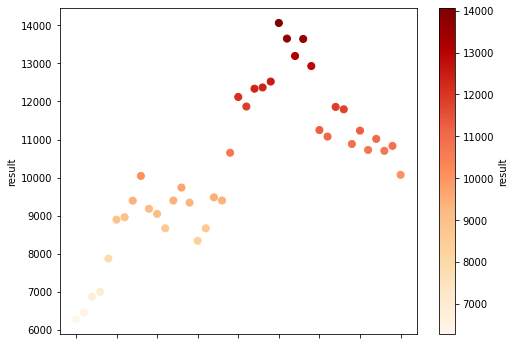

    param1        result
0     60.0   6273.417043
1     61.0   6461.288812
2     62.0   6870.518174
3     63.0   6999.241002
4     64.0   7873.762877
15    75.0   8340.700773
16    76.0   8667.824664
11    71.0   8668.199908
5     65.0   8894.778695
6     66.0   8959.331397
10    70.0   9045.953229
9     69.0   9181.566031
14    74.0   9342.944121
7     67.0   9395.325220
12    72.0   9398.025665
18    78.0   9398.756258
17    77.0   9481.639766
13    73.0   9738.378469
8     68.0  10044.250730
40   100.0  10072.534515
19    79.0  10653.795824
38    98.0  10703.286055
36    96.0  10726.792151
39    99.0  10832.610793
34    94.0  10883.417226
37    97.0  11017.394092
31    91.0  11077.520686
35    95.0  11234.261075
30    90.0  11249.920678
33    93.0  11794.319833
32    92.0  11856.808298
21    81.0  11867.236179
20    80.0  12118.706309
22    82.0  12335.610615
23    83.0  12368.496414
24    84.0  12523.407685
29    89.0  12930.840557
27    87.0  13195.252948
28    88.0  13642.180326


In [11]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [60, 101, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
  count += 1
  clear_output(wait=True)
  print("Loading...",count,'/',maxCount)
  # -- You can change variables below --
  usdt = 1000
  coin = 0

  stochTop = i / 100

  previousRow = dfTest.iloc[0]

  for index, row in dfTest.iterrows():
    #BUY
    if buyCondition(row, stochTop) and usdt > 0:
      coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
      usdt = 0

    #SELL
    elif sellCondition(row) and coin > 0:
      usdt = coin * row['close'] - (0.0007 * coin * row['close'])
      coin = 0

  myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
  dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))

<h2>Trix Parameters Optimizer</h2>

Loading... 260 / 260


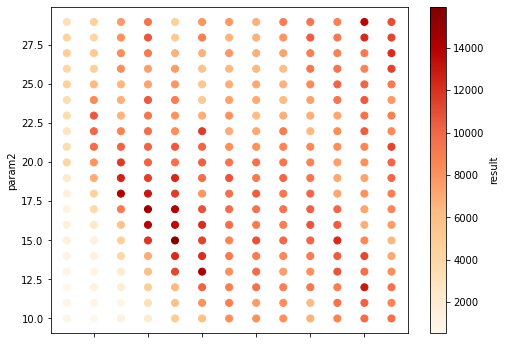

     param1  param2        result
20      6.0    10.0    540.182832
2       5.0    12.0    646.651324
1       5.0    11.0    841.593956
21      6.0    11.0    856.691274
0       5.0    10.0    880.338706
..      ...     ...           ...
87      9.0    17.0  14062.231542
103    10.0    13.0  14132.926637
48      7.0    18.0  14156.518949
67      8.0    17.0  14719.158957
85      9.0    15.0  15911.692317

[260 rows x 3 columns]


In [12]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [5, 18, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [10, 30, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    # -- Indicators, you can edit every value --
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'], trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    stochTop = 0.85

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>Stock RSI Optimizer</h1>

Loading... 29 / 29


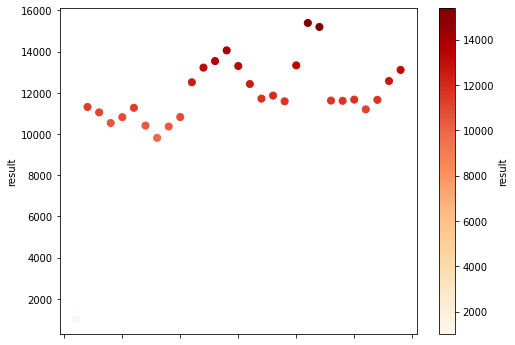

    param1        result
0      1.0   1000.000000
7      8.0   9816.776698
8      9.0  10366.738460
6      7.0  10411.608079
3      4.0  10536.109217
4      5.0  10820.819679
9     10.0  10826.661357
2      3.0  11052.778479
25    26.0  11198.337531
5      6.0  11275.211475
1      2.0  11314.382703
18    19.0  11589.848092
23    24.0  11613.797301
22    23.0  11625.225885
26    27.0  11661.899042
24    25.0  11672.007458
16    17.0  11720.764407
17    18.0  11867.526190
15    16.0  12430.671827
10    11.0  12514.828567
27    28.0  12577.630404
28    29.0  13113.010433
11    12.0  13225.662788
14    15.0  13303.891346
19    20.0  13334.392352
12    13.0  13543.411984
13    14.0  14062.231542
21    22.0  15198.742775
20    21.0  15393.059928


In [14]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [1, 30, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

    stochTop = 0.85

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))